# Analysing torsional vibrations in a 4-stroke engine
This is a very quick and dirty script for estimating the frequency distribution of the vibratory torque generated by a 4-stroke engine from cylinder pressure measurements.

In [1]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack #
import scipy.interpolate #

from aux_functions import get_average_pressure_cycle, apply_experimental_setup_corrections, \
    get_tangential_pressure, get_instant_torque, get_excitation_orders

The first step is importing some measured data and assigning it to a structured array

In [2]:
file_name = 'sample_data.h5'
data = {}
with h5py.File(file_name, 'r') as h5f:
    for field in list(h5f):
        data[field] = h5f[field].value

vib_signal = np.array(list(zip(data['time'], data['vibration_amplitude'], data['pip'])),
                      dtype={'names':['t', 'y', 'pip'], 'formats': ['float', 'float', 'float']})

At this point it is wise to plot what we imported. The series is too long to be able to distinguish any shape, but we can at least verify that the values are in the expected range.

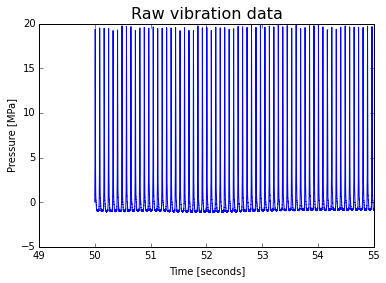

In [3]:
plt.plot(vib_signal['t'], vib_signal['y'])
plt.title('Raw vibration data', fontsize=16);
plt.xlabel('Time [seconds]')
plt.ylabel('{0}{1}'.format('Pressure', ' [MPa]'))
plt.show()

In order to see the shape of a single pressure cycle and verify the quality of our data, we plot all of them in the same graph.

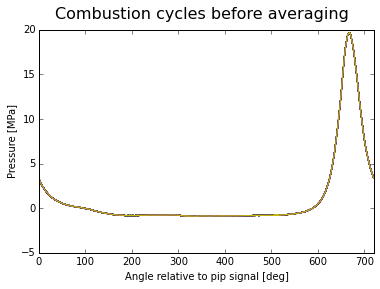

In [4]:
average_pressure_cycle = get_average_pressure_cycle(vib_signal, plot_all_cycles=True)

We can see that all the measured cycles are almost the same, and there are no outliers that should be excluded.
The next step after averaging is standardizing our signal. We want the top dead center (currently 58.8 degrees away from our reference) to be at zero. Additionally, we add a pressure offset of 1.205 MPa. The resulting plot is the following:

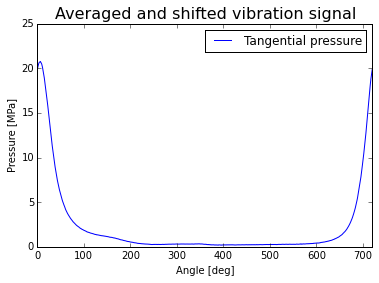

In [10]:
angle_tdc = 58.8  # Angle in degrees
pressure_offset = 0.270 + 0.935  # = 1.205 [MPa]
corrected_pressure_cycle = apply_experimental_setup_corrections(average_pressure_cycle, angle_tdc, pressure_offset)
plt.plot(corrected_pressure_cycle['angle'], corrected_pressure_cycle['pressure'])
plt.title('Averaged and shifted vibration signal', fontsize=16);
plt.legend(('Tangential pressure', ''), loc='best')
plt.xlabel('Angle [deg]')
plt.ylabel('Pressure [MPa]')
plt.xlim([0, 720])
plt.show()

The tangential pressure $P_T$, defined as the ratio between the generated torque and the cylinder pressure $P_C$, can be calculated through the following "tangential modulation": 

$P_T$ = $P_C \cdot sin(\theta) \cdot \left( 1 + \lambda \cdot cos(\theta) / \sqrt{1 - \lambda^2 \cdot cos^2(\theta)} \right)$

where $P_T$ is the tangential pressure, $P_C$ is the cylinder pressure, $\theta$ is the crank angle and $\lambda$ is the connecting rod ratio defined as $\lambda = \frac{\text{crank radius}}{\text{connecting rod length}}$


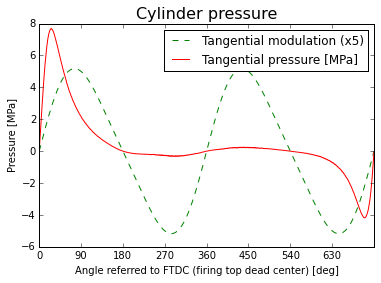

In [13]:
conrod_ratio = 0.274  # crank_throw / connecting_rod_length
tangential_pressure, tangential_modulation = get_tangential_pressure(corrected_pressure_cycle, conrod_ratio)

plt.plot(tangential_modulation[0], tangential_modulation[1]*5, '--g', label='Tangential modulation')
plt.plot(tangential_pressure[0], tangential_pressure[1], 'r', label='Tangential pressure [MPa]')
plt.legend(('Tangential modulation (x5)', 'Tangential pressure [MPa]'), loc='best')
plt.title("Cylinder pressure", fontsize=16)
plt.xticks(np.arange(0, 720, 90))
plt.xlabel('Angle referred to FTDC (firing top dead center) [deg]')
plt.ylabel('{0}{1}'.format('Pressure', ' [MPa]'))
plt.xlim([0, 720])
plt.show()

The tangential torque $\tau$ as a function of the crank angle $\theta$ can be calculated straightforwardly as:

$\tau(\theta) = P_T(\theta) \cdot \frac{\pi}{4} \cdot d_C^2 \cdot l_c \cdot N$

where $d_C$ is the cylinder diameter, $l_c$ is the crank radius and $N$ is the number of operative cylinders. Since $P_T$ is the only parameter having a functional dependency on $\theta$, both functions have the same shape.

In [15]:
crank_throw = 0.1075  # [m]
cylinder_diameter = 0.170  # [m]
instant_torque = get_instant_torque(tangential_pressure, cylinder_diameter, crank_throw, number_of_cylinders=16)

Now we are in position to do a Fourier analysis and determine the relative amplitude of the harmonic components in the engine torque.

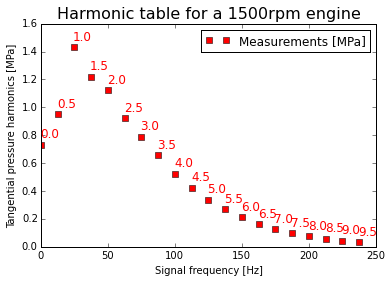

In [23]:
tangential_pressure_orders = get_excitation_orders(tangential_pressure, rpm=1500, max_order=9, plot_excitation_orders=False)
torque_orders = get_excitation_orders(instant_torque, rpm=1500, max_order=9, plot_excitation_orders=False)

plt.plot(tangential_pressure_orders['freq'], tangential_pressure_orders['abs'], 'sr', label='Measurements [MPa]')
plt.legend(('Measurements [MPa]', ''), loc='best')
for index_ in range(len(tangential_pressure_orders['freq'])):
    plt.text(tangential_pressure_orders['freq'][index_], tangential_pressure_orders['abs'][index_]+0.05,
               str(tangential_pressure_orders['order'][index_]), fontsize=12, color='r')
plt.title("Harmonic table for a 1500rpm engine", fontsize=16)
plt.xlabel('Signal frequency [Hz]')
plt.ylabel('{0}{1}'.format('Tangential pressure harmonics', ' [MPa]'))
plt.show()

DISCLAIMER: Ugly code. This is a first draft.